# Time series analysis from Kaggle Notebook
https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python

In [1]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [2]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')
df_daily.head()


,Unnamed: 0,date,calls,days_to_holiday
0,0,2014-01-01,153.0,0
1,1,2014-01-02,233.0,-1
2,2,2014-01-03,203.0,-2
3,3,2014-01-04,192.0,-3
4,4,2014-01-05,149.0,-4


In [3]:
# Prüfen und Spalte 'Unnamed: 0' entfernen, falls vorhanden
if 'Unnamed: 0' in df_daily.columns:
    df_daily = df_daily.drop(columns=['Unnamed: 0'])

# Prüfen und 'date' als Index setzen, falls nicht bereits gesetzt
if df_daily.index.name != 'date':
    if 'date' in df_daily.columns:
        df_daily['date'] = pd.to_datetime(df_daily['date'])
        df_daily.set_index('date', inplace=True)

In [4]:
# Prüfen und Spalte 'Unnamed: 0' entfernen, falls vorhanden
if 'Unnamed: 0' in df_hourly.columns:
    df_hourly = df_hourly.drop(columns=['Unnamed: 0'])

# Prüfen und 'date' als Index setzen, falls nicht bereits gesetzt
if df_hourly.index.name != 'date':
    if 'date' in df_hourly.columns:
        df_hourly['date'] = pd.to_datetime(df_hourly['date'])
        df_hourly.set_index('date', inplace=True)
df_hourly.head()

,calls,days_to_holiday
date,,
2020-07-01 00:00:00,1,-61
2020-07-01 01:00:00,5,-61
2020-07-01 02:00:00,4,-61
2020-07-01 03:00:00,2,-61
2020-07-01 04:00:00,1,-61


In [26]:
df_daily_test = df_daily_test.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_daily_test["date"] = pd.to_datetime(df_daily_test["date"])  # Falls noch nicht im Datetime-Format
df_daily_test = df_daily_test.set_index("date")  # Datum als Index setzen
df_daily_test["weekday"] = df_daily_test.index.dayofweek  # Montag=0, Sonntag=6

df_hourly_test = df_hourly_test.drop(columns=["Unnamed: 0"])  # Unnötige Spalte löschen
df_hourly_test["date"] = pd.to_datetime(df_hourly_test["date"])  # Falls noch nicht im Datetime-Format
df_hourly_test = df_hourly_test.set_index("date")  # Datum als Index setzen
df_hourly_test["weekday"] = df_hourly_test.index.dayofweek  # Montag=0, Sonntag=6

In [16]:
import optuna
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def objective_daily(trial):
    try:
        # NaN-Werte aus den Daten entfernen
        calls_clean = df_daily['calls'].dropna()

        # Alle Varianten für die Optimierung offen lassen
        error = trial.suggest_categorical("error", ["add", "mul"])
        trend = trial.suggest_categorical("trend", ["add", "mul", None])  
        seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])  
        seasonal_periods = 7  # Wöchentliche Saisonalität

        # ETS-Modell erstellen
        model = ETSModel(
            calls_clean, 
            error=error, 
            trend=trend, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods
        ).fit()

        return model.aic  # AIC als Optimierungswert

    except Exception as e:
        print(f"Fehler bei Trial {trial.number}: {e}")
        return float('inf')  # Falls das Modell fehlschlägt, bestrafen

# Optuna-Studie starten
study_daily = optuna.create_study(direction="minimize")
study_daily.optimize(objective_daily, n_trials=50)

# Beste Parameter und AIC-Wert ausgeben
print(f"Beste Parameter für df_daily: {study_daily.best_params}")
print(f"Bestes AIC für df_daily: {study_daily.best_value}")


[I 2025-02-20 08:30:38,283] A new study created in memory with name: no-name-90b1fa6f-9132-44f7-9e8f-e4ada3933f4d
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
[I 2025-02-20 08:30:39,754] Trial 0 finished with value: 36341.866206562896 and parameters: {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul'}. Best is trial 0 with value: 36341.866206562896.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
[I 2025-02-20 08:30:40,070] Trial 1 finished with value: 38235.80118527739 and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': None}. Best is trial 0 with value: 3634

Beste Parameter für df_daily: {'error': 'add', 'trend': None, 'seasonal': 'mul'}
Bestes AIC für df_daily: 36244.85676060652


In [17]:
import optuna
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

def objective_hourly(trial):
    try:
        # NaN-Werte aus den Daten entfernen
        calls_clean = df_hourly['calls'].dropna()

        # Alle Varianten für die Optimierung offen lassen
        error = trial.suggest_categorical("error", ["add", "mul"])
        trend = trial.suggest_categorical("trend", ["add", "mul", None])  
        seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])  
        seasonal_periods = 24  # Stündliche Saisonalität

        # ETS-Modell erstellen
        model = ETSModel(
            calls_clean, 
            error=error, 
            trend=trend, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods
        ).fit()

        return model.aic  # AIC als Optimierungswert

    except Exception as e:
        print(f"Fehler bei Trial {trial.number}: {e}")
        return float('inf')  # Falls das Modell fehlschlägt, bestrafen

# Optuna-Studie starten
study_hourly = optuna.create_study(direction="minimize")
study_hourly.optimize(objective_hourly, n_trials=50)

# Beste Parameter und AIC-Wert ausgeben
print(f"Beste Parameter für df_hourly: {study_hourly.best_params}")
print(f"Bestes AIC für df_hourly: {study_hourly.best_value}")


[I 2025-02-20 08:31:03,890] A new study created in memory with name: no-name-b9ab4643-5cb7-4547-a0e4-0bb5125a99b7
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:31:28,462] Trial 0 finished with value: 177950.07855421392 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 0 with value: 177950.07855421392.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:31:28,476] Trial 1 finished with value: inf and parameters: {'error': 'mul', 'trend': 'mul', 'seasonal': 'add'}. Best is trial 0 with value: 177950.07855421392.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Value

Fehler bei Trial 1: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 2: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 3: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 4: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 5: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 6: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 7: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 8: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 9: endog must be strictly positive when using multiplicative er

[I 2025-02-20 08:31:30,765] Trial 10 finished with value: 192146.656298313 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 177950.07855421392.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:31:32,078] Trial 11 finished with value: 192146.656298313 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 177950.07855421392.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:31:33,642] Trial 12 finished with value: 192146.656298313 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': None}. Best is trial 0 with value: 177950.07855421392.
c:\Us

Fehler bei Trial 29: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:34:56,919] Trial 30 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:35:07,291] Trial 31 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:35:17,964] Trial 32 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.920789553

Fehler bei Trial 35: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 36: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:35:50,401] Trial 37 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:35:50,426] Trial 38 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': 'mul'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Fehler bei Trial 38: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:36:00,981] Trial 39 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:36:11,495] Trial 40 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:36:22,080] Trial 41 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.920789553

Fehler bei Trial 44: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 45: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:36:54,070] Trial 46 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:37:04,469] Trial 47 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:37:04,469] Trial 48 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'add'}. Best is trial 28 with value: 177942.92078955367.
c:\Users\C

Fehler bei Trial 48: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 49: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Beste Parameter für df_hourly: {'error': 'add', 'trend': None, 'seasonal': 'add'}
Bestes AIC für df_hourly: 177942.92078955367


In [19]:
# Sicherstellen, dass der Index von df_hourly ein DatetimeIndex ist
df_hourly.index = pd.to_datetime(df_hourly.index)

# Slice des DataFrames ab dem Index Juli 2020
df_hourly_time_modified = df_hourly[df_hourly.index >= '2022-01-01']

# Sicherstellen, dass der Index von df_hourly ein DatetimeIndex ist
df_daily.index = pd.to_datetime(df_daily.index)

# Slice des DataFrames ab dem Index Juli 2020
df_daily_time_modified = df_daily[df_daily.index >= '2022-01-01']

In [20]:
def objective_daily(trial):
    try:
        # NaN-Werte aus den Daten entfernen
        calls_clean = df_daily['calls'].dropna()

        # Alle Varianten für die Optimierung offen lassen
        error = trial.suggest_categorical("error", ["add", "mul"])
        trend = trial.suggest_categorical("trend", ["add", "mul", None])  
        seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])  
        seasonal_periods = 7  # Wöchentliche Saisonalität

        # ETS-Modell erstellen
        model = ETSModel(
            calls_clean, 
            error=error, 
            trend=trend, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods
        ).fit()

        return model.aic  # AIC als Optimierungswert

    except Exception as e:
        print(f"Fehler bei Trial {trial.number}: {e}")
        return float('inf')  # Falls das Modell fehlschlägt, bestrafen

# Optuna-Studie starten
study_daily = optuna.create_study(direction="minimize")
study_daily.optimize(objective_daily, n_trials=50)

# Beste Parameter und AIC-Wert ausgeben
print(f"Beste Parameter für df_daily: {study_daily.best_params}")
print(f"Bestes AIC für df_daily: {study_daily.best_value}")


[I 2025-02-20 08:42:58,209] A new study created in memory with name: no-name-9a5ae4fc-dad3-4ef2-ab8f-aa773654bca9
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
[I 2025-02-20 08:42:58,791] Trial 0 finished with value: 36247.65585448097 and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'mul'}. Best is trial 0 with value: 36247.65585448097.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
[I 2025-02-20 08:42:59,235] Trial 1 finished with value: 36324.04624408157 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 0 with value: 36247

Beste Parameter für df_daily: {'error': 'add', 'trend': 'mul', 'seasonal': 'mul'}
Bestes AIC für df_daily: 36247.65585448097


In [21]:
def objective_hourly(trial):
    try:
        # NaN-Werte aus den Daten entfernen
        calls_clean = df_hourly['calls'].dropna()

        # Alle Varianten für die Optimierung offen lassen
        error = trial.suggest_categorical("error", ["add", "mul"])
        trend = trial.suggest_categorical("trend", ["add", "mul", None])  
        seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])  
        seasonal_periods = 24  # Stündliche Saisonalität

        # ETS-Modell erstellen
        model = ETSModel(
            calls_clean, 
            error=error, 
            trend=trend, 
            seasonal=seasonal, 
            seasonal_periods=seasonal_periods
        ).fit()

        return model.aic  # AIC als Optimierungswert

    except Exception as e:
        print(f"Fehler bei Trial {trial.number}: {e}")
        return float('inf')  # Falls das Modell fehlschlägt, bestrafen

# Optuna-Studie starten
study_hourly = optuna.create_study(direction="minimize")
study_hourly.optimize(objective_hourly, n_trials=50)

# Beste Parameter und AIC-Wert ausgeben
print(f"Beste Parameter für df_hourly: {study_hourly.best_params}")
print(f"Bestes AIC für df_hourly: {study_hourly.best_value}")

[I 2025-02-20 08:43:23,441] A new study created in memory with name: no-name-0ce7cb65-cee6-46ad-9ff9-d9cf99c772c7
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:23,452] Trial 0 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'add'}. Best is trial 0 with value: inf.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Fehler bei Trial 0: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:43:24,517] Trial 1 finished with value: 192146.656298313 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': None}. Best is trial 1 with value: 192146.656298313.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:24,639] Trial 2 finished with value: 192139.5885098887 and parameters: {'error': 'add', 'trend': None, 'seasonal': None}. Best is trial 2 with value: 192139.5885098887.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:24,639] Trial 3 finished with value: inf and parameters: {'error': 'mul', 'trend': 'add', 'seasonal': None}. Best is trial 2 with value: 192139.5885098887.
c:\Users\ChiaraVogt\minic

Fehler bei Trial 3: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:43:35,400] Trial 4 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:35,419] Trial 5 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': None}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:35,419] Trial 6 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': 'mul'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Li

Fehler bei Trial 5: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 6: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 7: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:43:51,254] Trial 8 finished with value: 177950.07855421392 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:51,270] Trial 9 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:43:51,270] Trial 10 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'mul'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda

Fehler bei Trial 9: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 10: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:44:06,480] Trial 11 finished with value: 177950.07855421392 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:44:22,181] Trial 12 finished with value: 177950.07855421392 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:44:37,892] Trial 13 finished with value: 177950.07855421392 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 4 with value: 177942.920789553

Fehler bei Trial 14: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:44:48,757] Trial 15 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:45:00,072] Trial 16 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:45:00,094] Trial 17 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'mul'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\Chiar

Fehler bei Trial 17: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:45:11,689] Trial 18 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:45:22,305] Trial 19 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:45:22,305] Trial 20 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'mul'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\Chiar

Fehler bei Trial 20: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:45:33,132] Trial 21 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:45:43,704] Trial 22 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:45:54,365] Trial 23 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.

Fehler bei Trial 25: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 26: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:46:15,616] Trial 27 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:46:15,631] Trial 28 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'mul'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:46:15,631] Trial 29 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\minicond

Fehler bei Trial 28: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 29: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:46:26,365] Trial 30 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:46:36,806] Trial 31 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:46:47,644] Trial 32 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.

Fehler bei Trial 36: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:47:20,200] Trial 37 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:47:20,210] Trial 38 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': None}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Fehler bei Trial 38: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:47:36,338] Trial 39 finished with value: 177950.07855421392 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:47:36,356] Trial 40 finished with value: inf and parameters: {'error': 'mul', 'trend': None, 'seasonal': 'mul'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Fehler bei Trial 40: endog must be strictly positive when using multiplicative error, trend or seasonal components.


[I 2025-02-20 08:47:47,139] Trial 41 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:47:58,335] Trial 42 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
[I 2025-02-20 08:48:09,769] Trial 43 finished with value: 177942.92078955367 and parameters: {'error': 'add', 'trend': None, 'seasonal': 'add'}. Best is trial 4 with value: 177942.92078955367.

Fehler bei Trial 48: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Fehler bei Trial 49: endog must be strictly positive when using multiplicative error, trend or seasonal components.
Beste Parameter für df_hourly: {'error': 'add', 'trend': None, 'seasonal': 'add'}
Bestes AIC für df_hourly: 177942.92078955367


In [71]:
df_cleaned = df_daily.dropna()  # Entfernen von NaN-Werten
ets_model_daily = ETSModel(
    df_cleaned['calls'], 
    error='add', 
    trend='mul', 
    seasonal='mul', 
    seasonal_periods=7  # Wöchentliche Saisonalität
).fit()

ets_model_hourly = ETSModel(
    df_hourly['calls'], 
    error='add', 
    trend=None, 
    seasonal='add', 
    seasonal_periods=24  # Tägliche Saisonalität (stündliche Daten)
).fit()

# DAILY AB 2022
ets_model_daily_cut = ETSModel(
    df_daily_time_modified['calls'], 
    error='add', 
    trend='mul', 
    seasonal='mul', 
    seasonal_periods=7  # Wöchentliche Saisonalität
).fit()

# HOURLY AB 2022
ets_model_hourly_cut = ETSModel(
    df_hourly_time_modified['calls'], 
    error='add', 
    trend=None, 
    seasonal='add', 
    seasonal_periods=24  # Tägliche Saisonalität (stündliche Daten)
).fit()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [72]:
# VORHERSAGE FÜR HALBJAHR 2024 
forecast_daily = ets_model_daily.forecast(steps=len(df_daily_test))
forecast_daily_cut = ets_model_daily_cut.forecast(steps=len(df_daily_test))
forecast_hourly = ets_model_hourly.forecast(steps=len(df_hourly_test))
forecast_hourly_cut = ets_model_hourly_cut.forecast(steps=len(df_hourly_test))

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


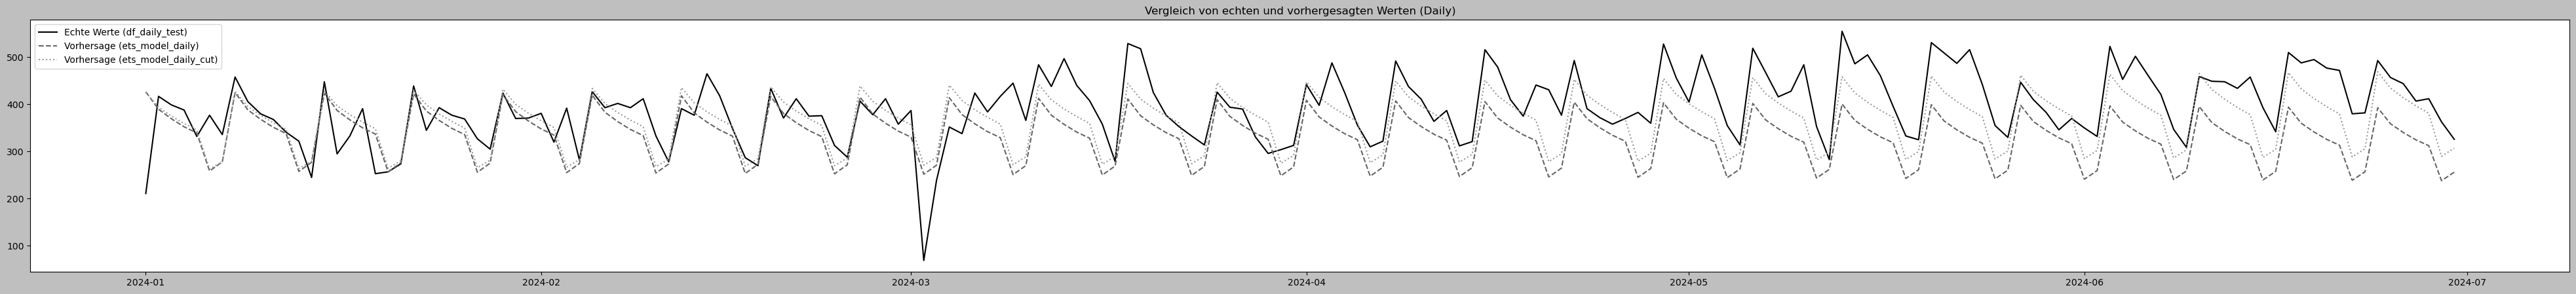

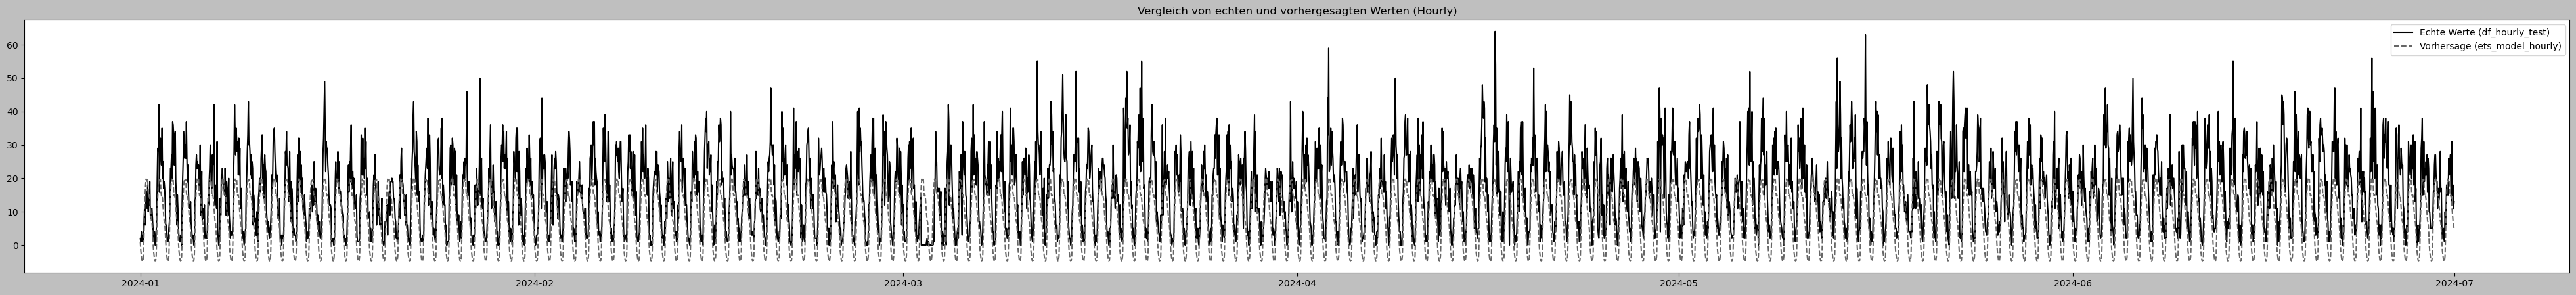

In [ ]:
# VISUALISIERUNG

# Tägliche Vorhersage plotten
plt.figure(figsize=(50, 5))
plt.plot(df_daily_test.index, df_daily_test['calls'], label="Echte Werte (df_daily_test)")
plt.plot(df_daily_test.index, forecast_daily, label="Vorhersage (ets_model_daily)", linestyle="dashed")
plt.plot(df_daily_test.index, forecast_daily_cut, label="Vorhersage (ets_model_daily_cut)", linestyle="dotted")
plt.legend()
plt.title("Vergleich von echten und vorhergesagten Werten (Daily)")
plt.show()

# Stündliche Vorhersage plotten
plt.figure(figsize=(50, 5))
plt.plot(df_hourly_test.index, df_hourly_test['calls'], label="Echte Werte (df_hourly_test)")
plt.plot(df_hourly_test.index, forecast_hourly, label="Vorhersage (ets_model_hourly)", linestyle="dashed")
#plt.plot(df_hourly_test.index, forecast_hourly_cut, label="Vorhersage (ets_model_hourly_cut)", linestyle="dotted")
plt.legend()
plt.title("Vergleich von echten und vorhergesagten Werten (Hourly)")
plt.show()


# Berechnung  der Güte mit Fehlermetriken

In [80]:
# WERTE FÜR DAILY
# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(df_daily_test['calls'], forecast_daily)

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_daily_test['calls'] - forecast_daily) / df_daily_test['calls'])) * 100

# 3. MSE (Mean Squared Error)
mse = mean_squared_error(df_daily_test['calls'], forecast_daily)

# 4. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Ergebnisse ausgeben
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 123.0684
MAPE: nan%
MSE: 21031.1000
RMSE: 145.0210


C:\Users\ChiaraVogt\AppData\Local\Temp\ipykernel_14804\3192110371.py:6: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((df_daily_test['calls'] - forecast_daily) / df_daily_test['calls'])) * 100


In [57]:
# WERTE FÜR HOURLY
# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(df_hourly_test['calls'], forecast_hourly)

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_hourly_test['calls'] - forecast_hourly) / df_hourly_test['calls'])) * 100

# 3. MSE (Mean Squared Error)
mse = mean_squared_error(df_hourly_test['calls'], forecast_hourly)

# 4. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Ergebnisse ausgeben
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 8.6300
MAPE: inf%
MSE: 109.2137
RMSE: 10.4505


In [58]:
# WERTE FÜR DAILY AB 2022
# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(df_daily_test['calls'], forecast_daily_cut)

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_daily_test['calls'] - forecast_daily_cut) / df_daily_test['calls'])) * 100

# 3. MSE (Mean Squared Error)
mse = mean_squared_error(df_daily_test['calls'], forecast_daily_cut)

# 4. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Ergebnisse ausgeben
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 44.9854
MAPE: 12.8348%
MSE: 3423.7441
RMSE: 58.5128


In [59]:
# WERTE FÜR HOURLY AB 2022
# 1. MAE (Mean Absolute Error)
mae = mean_absolute_error(df_hourly_test['calls'], forecast_hourly_cut)

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((df_hourly_test['calls'] - forecast_hourly_cut) / df_hourly_test['calls'])) * 100

# 3. MSE (Mean Squared Error)
mse = mean_squared_error(df_hourly_test['calls'], forecast_hourly_cut)

# 4. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# Ergebnisse ausgeben
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 8.5700
MAPE: inf%
MSE: 108.3091
RMSE: 10.4072


In [7]:
df_daily.interpolate(method='time', inplace=True)
df_hourly.interpolate(method='time', inplace=True)

In [8]:
ets_model_daily = ETSModel(df_daily['calls'], 
                 error='add', 
                 trend='add', 
                 seasonal='add', 
                 seasonal_periods=7)  # z.B. wöchentliche Saisonalität
fit_daily = ets_model_daily.fit()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC: 36647.495853726046
BIC: 36728.13524686834
Log-Likelihood: -18310.747926863023
Sum of Squared Residuals (SSR): 4842516.250688531
MSE: 1325.990211031909
RMSE: 36.41414850071204
MAE: 26.187980932334288
MAPE: 16.46%


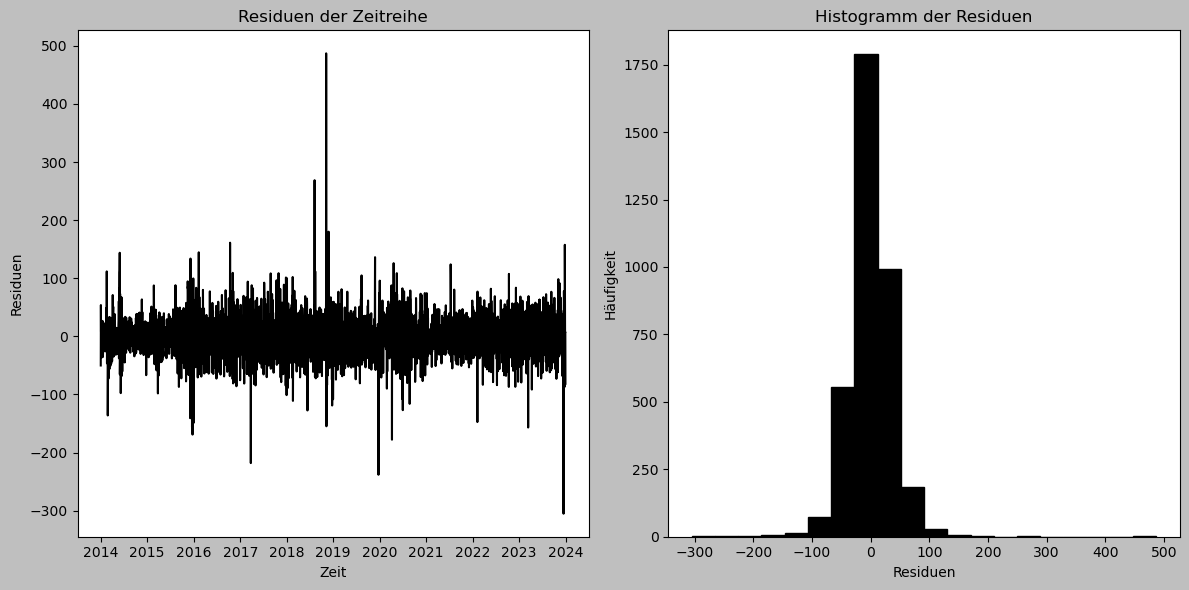

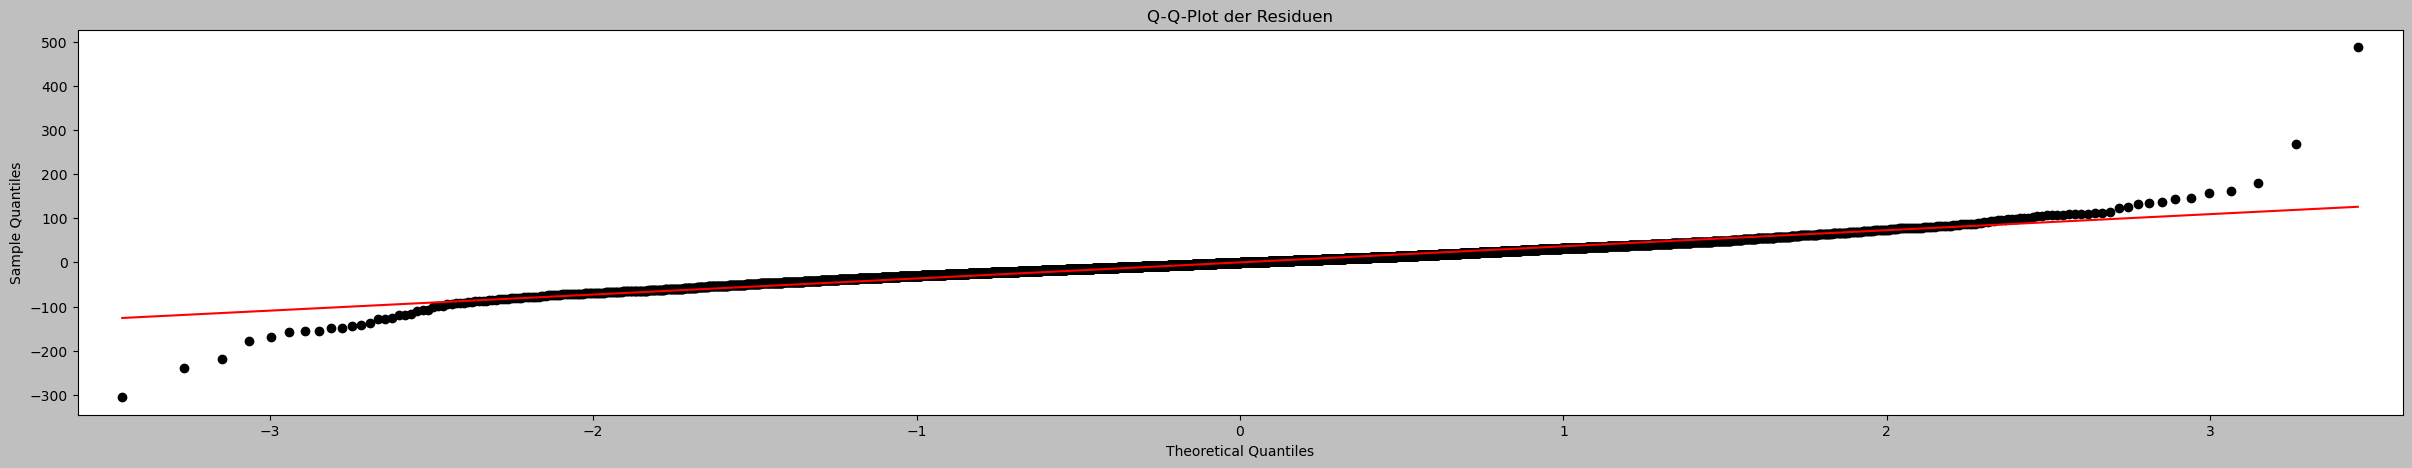

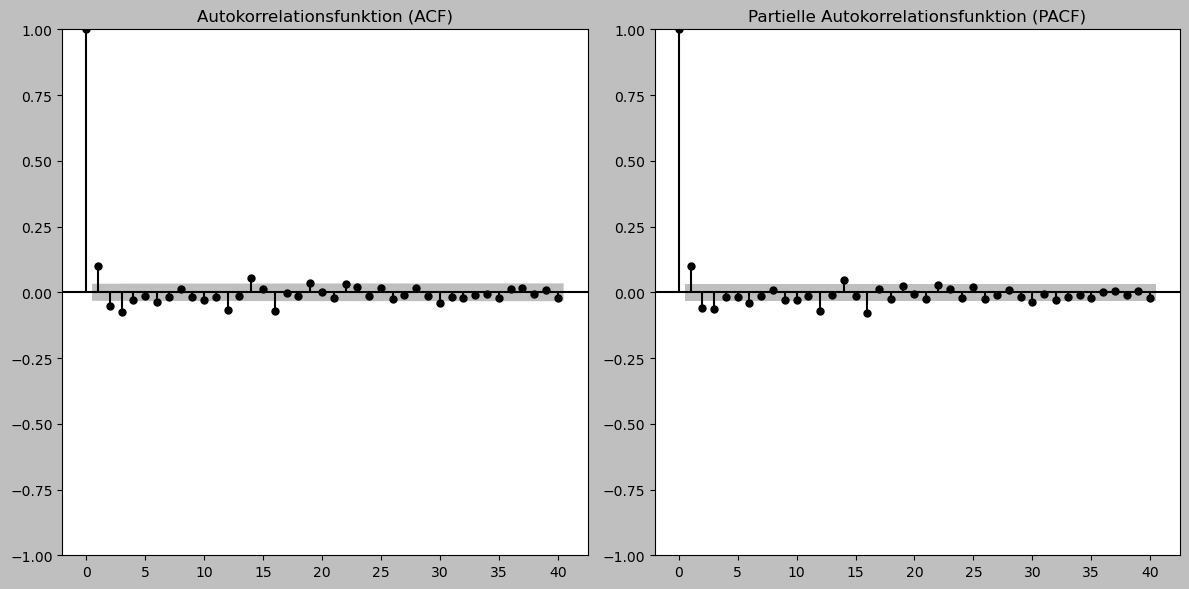

In [9]:
# Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC)
print(f"AIC: {fit_daily.aic}")
print(f"BIC: {fit_daily.bic}")

# Log-Likelihood des Modells
print(f"Log-Likelihood: {fit_daily.llf}")

# Summe der quadrierten Residuen (SSR)
print(f"Sum of Squared Residuals (SSR): {fit_daily.sse}")

# Tatsächliche Werte und vorhergesagte Werte
y_true = df_daily['calls']
y_pred = fit_daily.fittedvalues

# Mean Squared Error (MSE) und Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
print(f"MAPE: {mape:.2f}%")

# Residuen des ETS-Modells extrahieren
residuals = fit_daily.resid

# Residuen plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Zeitreihenplot der Residuen
axes[0].plot(residuals)
axes[0].set_title("Residuen der Zeitreihe")
axes[0].set_xlabel("Zeit")
axes[0].set_ylabel("Residuen")

# Histogramm der Residuen
axes[1].hist(residuals, bins=20, edgecolor="k")
axes[1].set_title("Histogramm der Residuen")
axes[1].set_xlabel("Residuen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# Q-Q-Plot der Residuen
sm.qqplot(residuals, line="s")
plt.title("Q-Q-Plot der Residuen")
plt.show()

# ACF und PACF der Residuen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], lags=40)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.tight_layout()
plt.show()


In [10]:
ets_model_hourly = ETSModel(df_hourly['calls'], 
                 error='add', 
                 trend='add', 
                 seasonal='add', 
                 seasonal_periods=24)  # z.B. wöchentliche Saisonalität
fit_hourly = ets_model_hourly.fit()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


AIC: 177950.07855421392
BIC: 178200.0351831717
Log-Likelihood: -88945.03927710696
Sum of Squared Residuals (SSR): 590798.7669493258
MSE: 19.246767231864926
RMSE: 4.387113770107281
MAE: 3.2610825396963907
MAPE: inf%


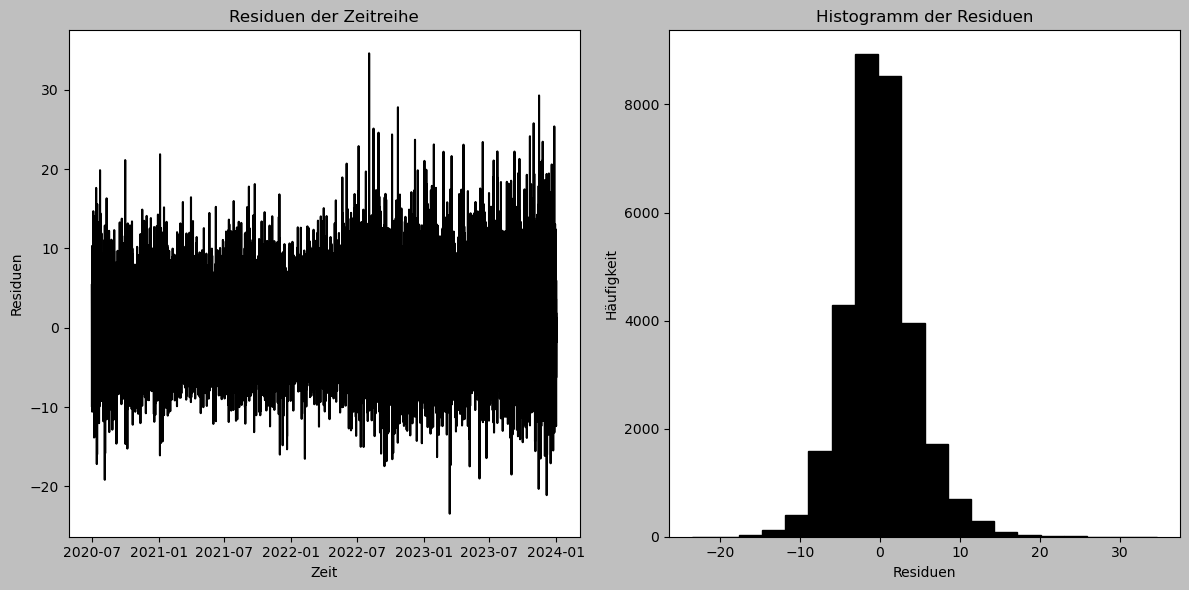

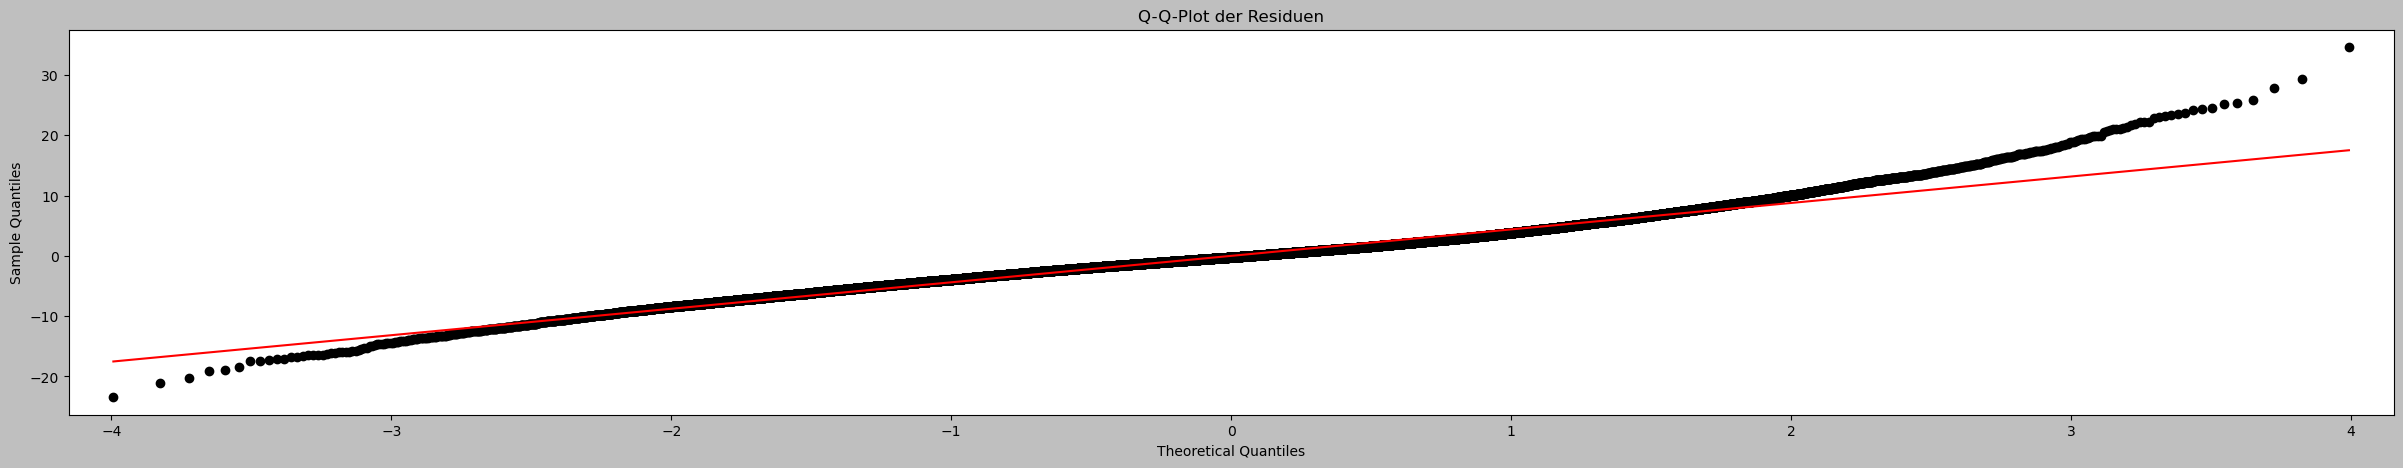

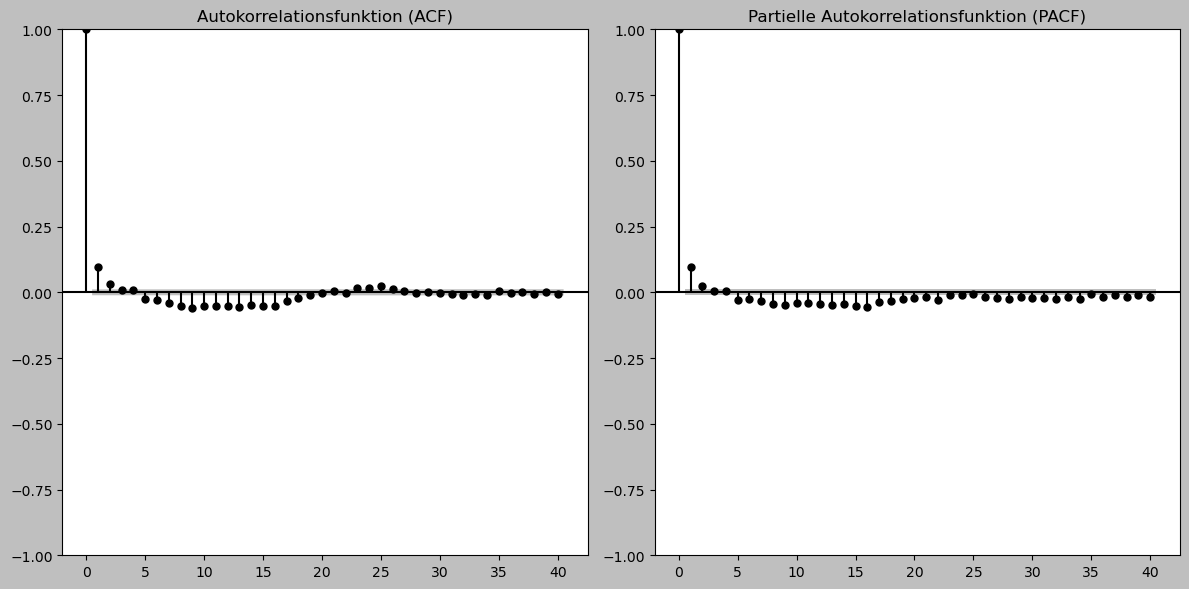

In [11]:
# Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC)
print(f"AIC: {fit_hourly.aic}")
print(f"BIC: {fit_hourly.bic}")

# Log-Likelihood des Modells
print(f"Log-Likelihood: {fit_hourly.llf}")

# Summe der quadrierten Residuen (SSR)
print(f"Sum of Squared Residuals (SSR): {fit_hourly.sse}")

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tatsächliche Werte und vorhergesagte Werte
y_true = df_hourly['calls']
y_pred = fit_hourly.fittedvalues

# Mean Squared Error (MSE) und Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
print(f"MAPE: {mape:.2f}%")


# Residuen des ETS-Modells extrahieren
residuals = fit_hourly.resid

# Residuen plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Zeitreihenplot der Residuen
axes[0].plot(residuals)
axes[0].set_title("Residuen der Zeitreihe")
axes[0].set_xlabel("Zeit")
axes[0].set_ylabel("Residuen")

# Histogramm der Residuen
axes[1].hist(residuals, bins=20, edgecolor="k")
axes[1].set_title("Histogramm der Residuen")
axes[1].set_xlabel("Residuen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# Q-Q-Plot der Residuen
sm.qqplot(residuals, line="s")
plt.title("Q-Q-Plot der Residuen")
plt.show()

# ACF und PACF der Residuen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], lags=40)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.tight_layout()
plt.show()


Die Werte sind ok, aber noch nicht wirklich optimal... Es erfolgt nun eine Hyperparameteroptimierung mittels Grid-Search.

In [38]:
import optuna
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def objective(trial):
    error = trial.suggest_categorical("error", ["add", "mul"])
    trend = trial.suggest_categorical("trend", ["add", "mul", None])
    seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])
    seasonal_periods = 7
    
    try:
        model = ExponentialSmoothing(
            df_daily['calls'], 
            seasonal=seasonal, 
            trend=trend, 
            seasonal_periods=seasonal_periods
        ).fit(optimized=True)
        return model.aic
    except:
        return float('inf')

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f"Beste Parameter: {study.best_params}")
print(f"Bestes AIC: {study.best_value}")

[I 2025-01-21 14:25:02,102] A new study created in memory with name: no-name-ae8b9119-0222-4f8a-8f1e-6b7bfa9621da
[I 2025-01-21 14:25:02,363] Trial 0 finished with value: 28338.730284527945 and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': None}. Best is trial 0 with value: 28338.730284527945.
[I 2025-01-21 14:25:02,996] Trial 1 finished with value: 26266.094063979228 and parameters: {'error': 'mul', 'trend': 'add', 'seasonal': 'mul'}. Best is trial 1 with value: 26266.094063979228.
[I 2025-01-21 14:25:04,446] Trial 2 finished with value: 26348.85506550329 and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'add'}. Best is trial 1 with value: 26266.094063979228.
[I 2025-01-21 14:25:04,627] Trial 3 finished with value: 28338.730284527945 and parameters: {'error': 'mul', 'trend': 'mul', 'seasonal': None}. Best is trial 1 with value: 26266.094063979228.
[I 2025-01-21 14:25:04,744] Trial 4 finished with value: 26274.557843604332 and parameters: {'error': 'mul', 'trend':

Beste Parameter: {'error': 'mul', 'trend': None, 'seasonal': 'mul'}
Bestes AIC: 26199.077170414825


In [35]:
def objective(trial):
    error = trial.suggest_categorical("error", ["add", "mul"])
    trend = trial.suggest_categorical("trend", ["add", "mul", None])
    seasonal = trial.suggest_categorical("seasonal", ["add", "mul", None])
    
    seasonal_periods = 24  # Feste Vorgabe der Saisonalitätsperiode
    
    try:
        model = ExponentialSmoothing(
            df_hourly['calls'], 
            seasonal=seasonal, 
            trend=trend, 
            seasonal_periods=seasonal_periods
        ).fit(optimized=True)
        return model.aic
    except:
        return float('inf')

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print(f"Beste Parameter: {study.best_params}")
print(f"Bestes AIC: {study.best_value}")


[I 2025-01-21 12:38:16,275] A new study created in memory with name: no-name-fd990186-d331-43e7-a1c9-a255cd5371c2
[I 2025-01-21 12:38:20,923] Trial 0 finished with value: 90793.06826314091 and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'add'}. Best is trial 0 with value: 90793.06826314091.
[I 2025-01-21 12:38:20,927] Trial 1 finished with value: inf and parameters: {'error': 'add', 'trend': 'mul', 'seasonal': 'mul'}. Best is trial 0 with value: 90793.06826314091.
[I 2025-01-21 12:38:20,927] Trial 2 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'mul'}. Best is trial 0 with value: 90793.06826314091.
[I 2025-01-21 12:38:20,938] Trial 3 finished with value: inf and parameters: {'error': 'add', 'trend': 'add', 'seasonal': 'mul'}. Best is trial 0 with value: 90793.06826314091.
[I 2025-01-21 12:38:20,938] Trial 4 finished with value: inf and parameters: {'error': 'add', 'trend': None, 'seasonal': 'mul'}. Best is trial 0 with value: 90793.06

Beste Parameter: {'error': 'add', 'trend': None, 'seasonal': 'add'}
Bestes AIC: 90754.22823314572


Festgelegte Seasonality auf 24, davor war das beste Ergebnis bei einer Seasonality: 4. das hat super komische Muster in der ACF und PACF ergeben.

In [18]:
ets_model_daily1 = ETSModel(df_daily['calls'], 
                 error='mul', 
                 trend=None, 
                 seasonal='mul', 
                 seasonal_periods=7)  # z.B. wöchentliche Saisonalität
fit_daily1 = ets_model_daily1.fit()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC: 36592.09714396247
BIC: 36660.33047662133
Log-Likelihood: -18285.048571981235
Sum of Squared Residuals (SSR): 64.15182486834573
MSE: 1312.551020196939
RMSE: 36.229146004245514
MAE: 26.0426441818666
MAPE: 15.84%


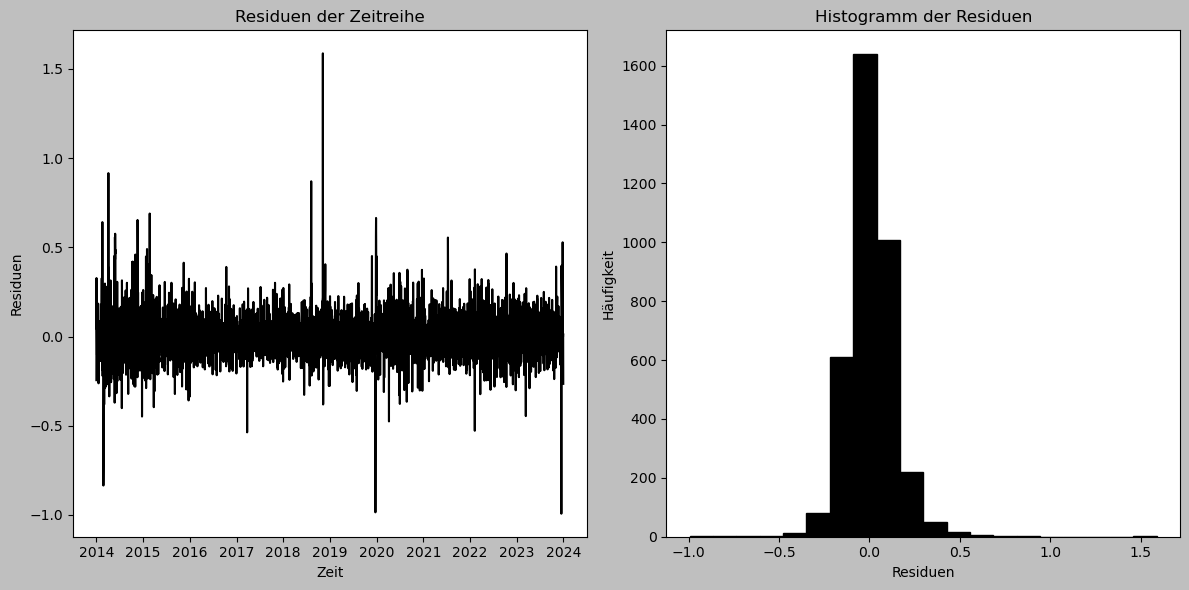

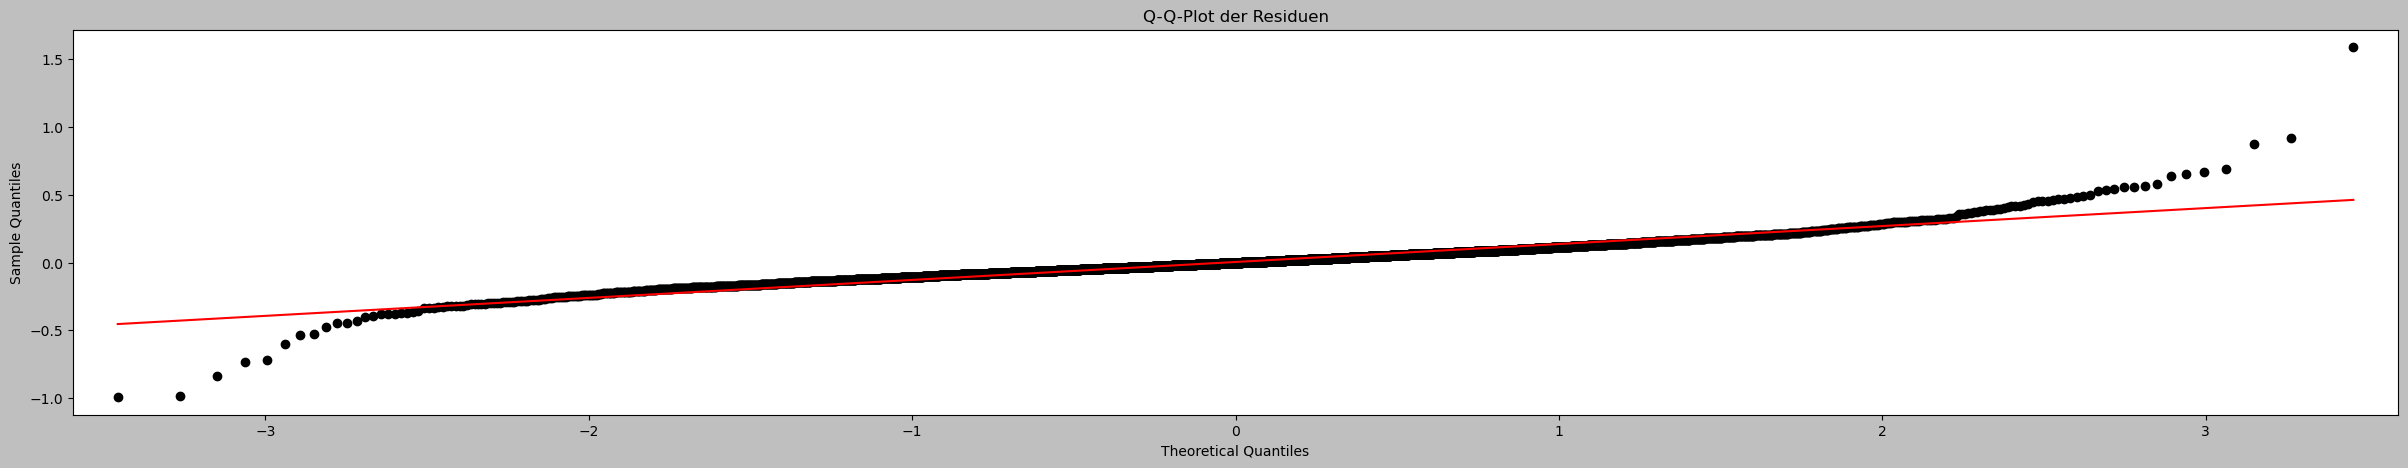

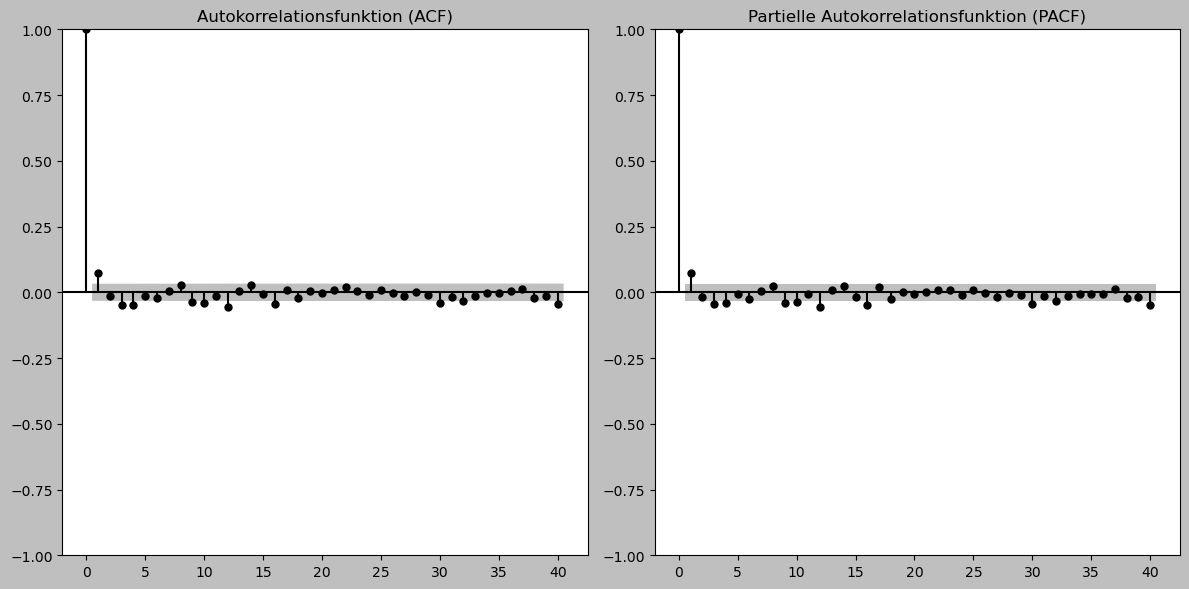

In [19]:
# Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC)
print(f"AIC: {fit_daily1.aic}")
print(f"BIC: {fit_daily1.bic}")

# Log-Likelihood des Modells
print(f"Log-Likelihood: {fit_daily1.llf}")

# Summe der quadrierten Residuen (SSR)
print(f"Sum of Squared Residuals (SSR): {fit_daily1.sse}")

# Tatsächliche Werte und vorhergesagte Werte
y_true = df_daily['calls']
y_pred = fit_daily1.fittedvalues

# Mean Squared Error (MSE) und Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
print(f"MAPE: {mape:.2f}%")

# Residuen des ETS-Modells extrahieren
residuals = fit_daily1.resid

# Residuen plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Zeitreihenplot der Residuen
axes[0].plot(residuals)
axes[0].set_title("Residuen der Zeitreihe")
axes[0].set_xlabel("Zeit")
axes[0].set_ylabel("Residuen")

# Histogramm der Residuen
axes[1].hist(residuals, bins=20, edgecolor="k")
axes[1].set_title("Histogramm der Residuen")
axes[1].set_xlabel("Residuen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# Q-Q-Plot der Residuen
sm.qqplot(residuals, line="s")
plt.title("Q-Q-Plot der Residuen")
plt.show()

# ACF und PACF der Residuen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], lags=40)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.tight_layout()
plt.show()

In [20]:
ets_model_hourly1 = ETSModel(df_hourly['calls'], 
                 error='add', 
                 trend=None, 
                 seasonal='add', 
                 seasonal_periods=24)  # z.B. wöchentliche Saisonalität
fit_hourly1 = ets_model_hourly1.fit()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


AIC: 177942.92078955367
BIC: 178176.2136432476
Log-Likelihood: -88943.46039477683
Sum of Squared Residuals (SSR): 590737.993313949
MSE: 19.244787376659794
RMSE: 4.386888119915961
MAE: 3.2607877968990184
MAPE: inf%


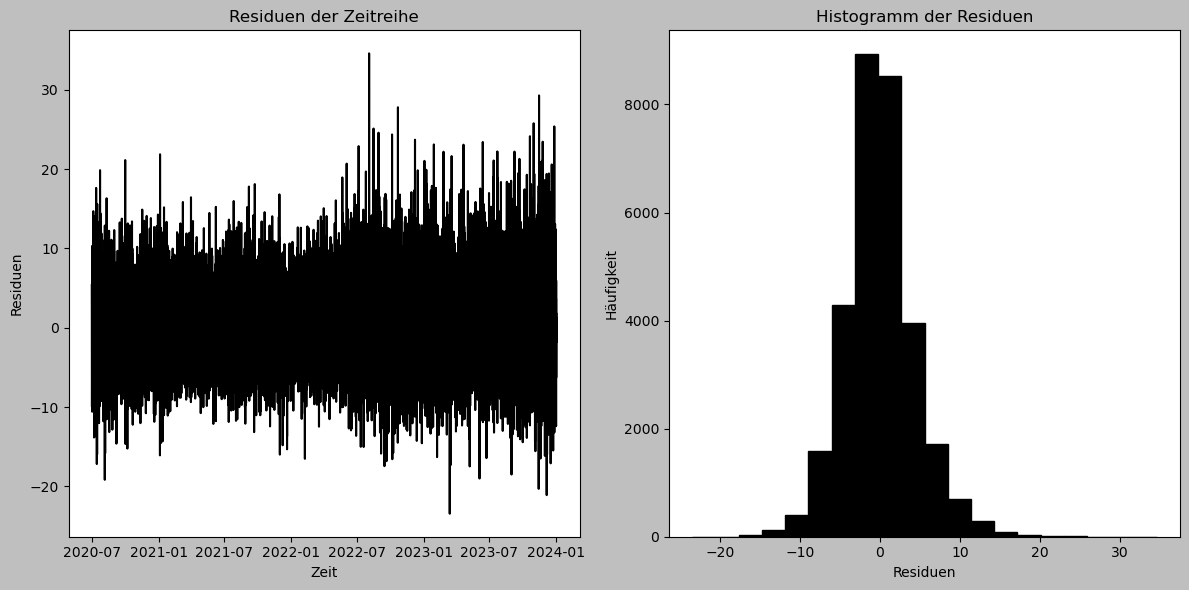

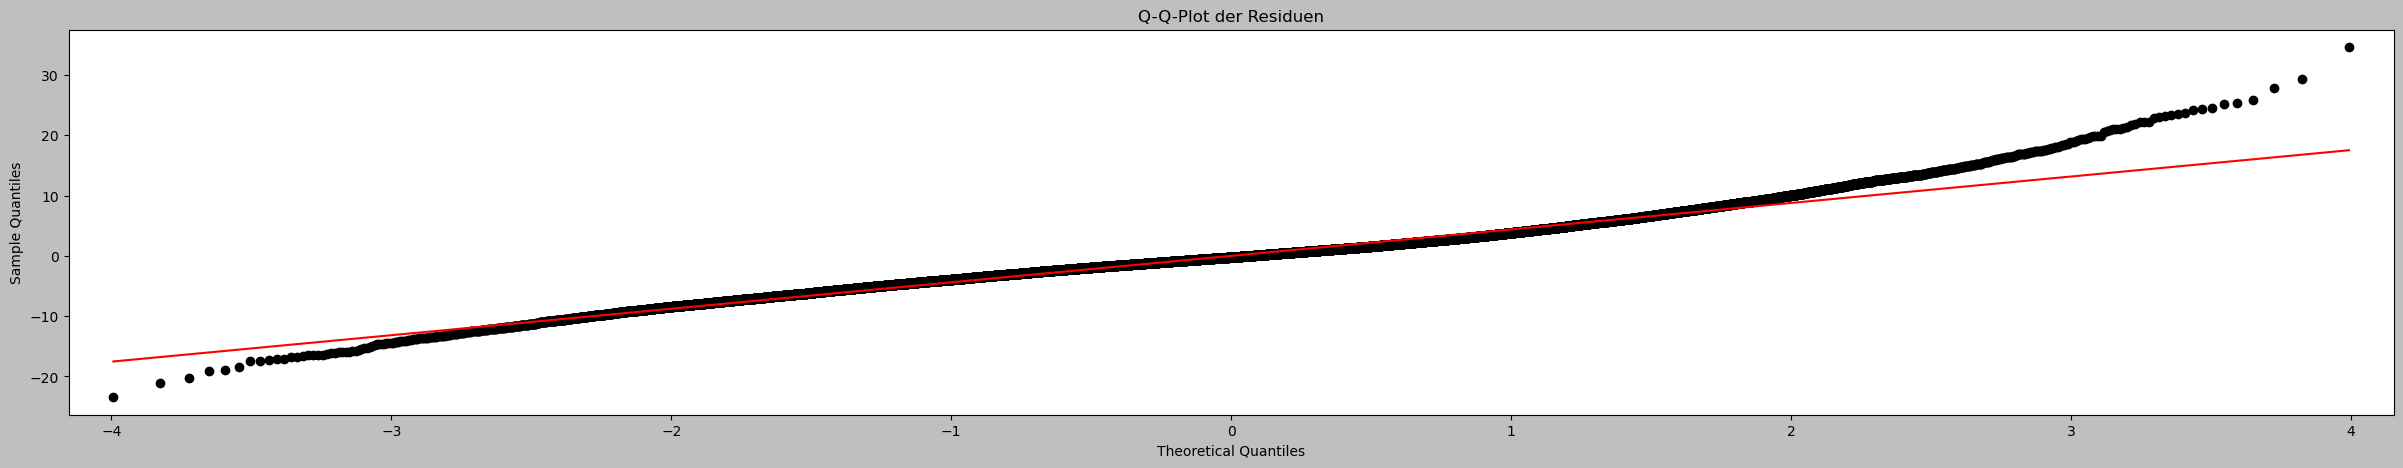

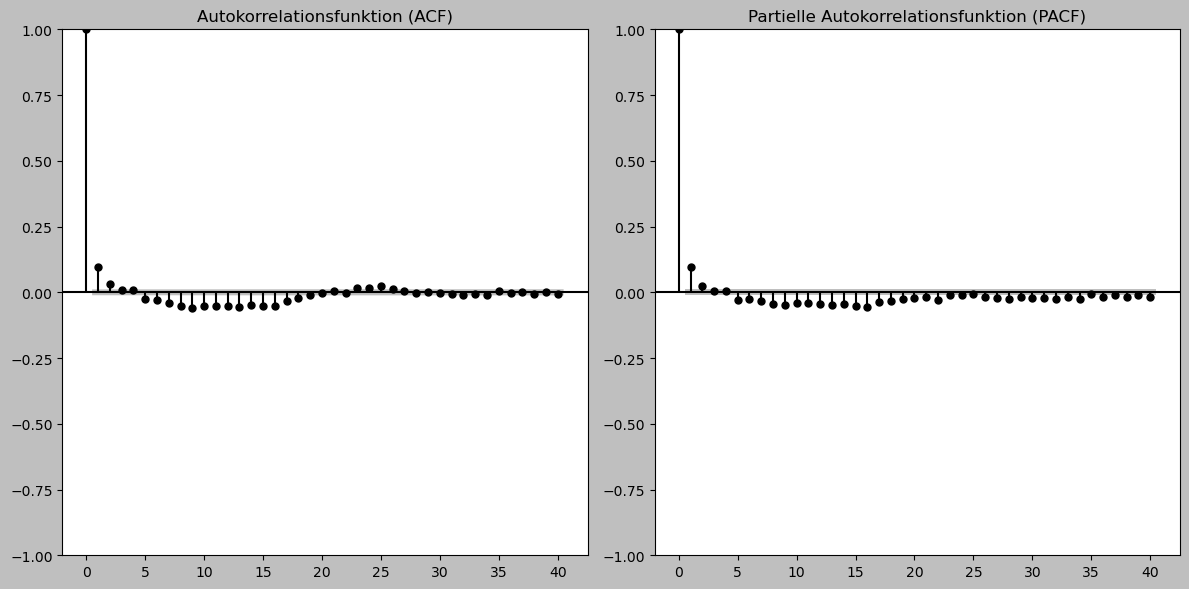

In [21]:
# Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC)
print(f"AIC: {fit_hourly1.aic}")
print(f"BIC: {fit_hourly1.bic}")

# Log-Likelihood des Modells
print(f"Log-Likelihood: {fit_hourly1.llf}")

# Summe der quadrierten Residuen (SSR)
print(f"Sum of Squared Residuals (SSR): {fit_hourly1.sse}")

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tatsächliche Werte und vorhergesagte Werte
y_true = df_hourly['calls']
y_pred = fit_hourly1.fittedvalues

# Mean Squared Error (MSE) und Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
print(f"MAPE: {mape:.2f}%")


# Residuen des ETS-Modells extrahieren
residuals = fit_hourly1.resid

# Residuen plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Zeitreihenplot der Residuen
axes[0].plot(residuals)
axes[0].set_title("Residuen der Zeitreihe")
axes[0].set_xlabel("Zeit")
axes[0].set_ylabel("Residuen")

# Histogramm der Residuen
axes[1].hist(residuals, bins=20, edgecolor="k")
axes[1].set_title("Histogramm der Residuen")
axes[1].set_xlabel("Residuen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# Q-Q-Plot der Residuen
sm.qqplot(residuals, line="s")
plt.title("Q-Q-Plot der Residuen")
plt.show()

# ACF und PACF der Residuen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], lags=40)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.tight_layout()
plt.show()

In [22]:
ets_model_daily2 = ETSModel(df_daily['calls'], 
                 error='mul', 
                 trend='add', 
                 seasonal='mul', 
                 seasonal_periods=30,
                 damped_trend=True)

ets_model_hourly2 = ETSModel(df_hourly['calls'], 
                 error='add', 
                 trend='add', 
                 seasonal='add', 
                 seasonal_periods=168,
                 damped_trend=True)

fit_daily2 = ets_model_daily2.fit()
fit_hourly2 = ets_model_hourly2.fit()

c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\ChiaraVogt\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 38768.969979586334
BIC: 38998.482098529785
Log-Likelihood: -19347.484989793167
Sum of Squared Residuals (SSR): 113.4275424054944
MSE: 2345.065129663551
RMSE: 48.425872523513206
MAE: 35.78677923258875
MAPE: 20.06%


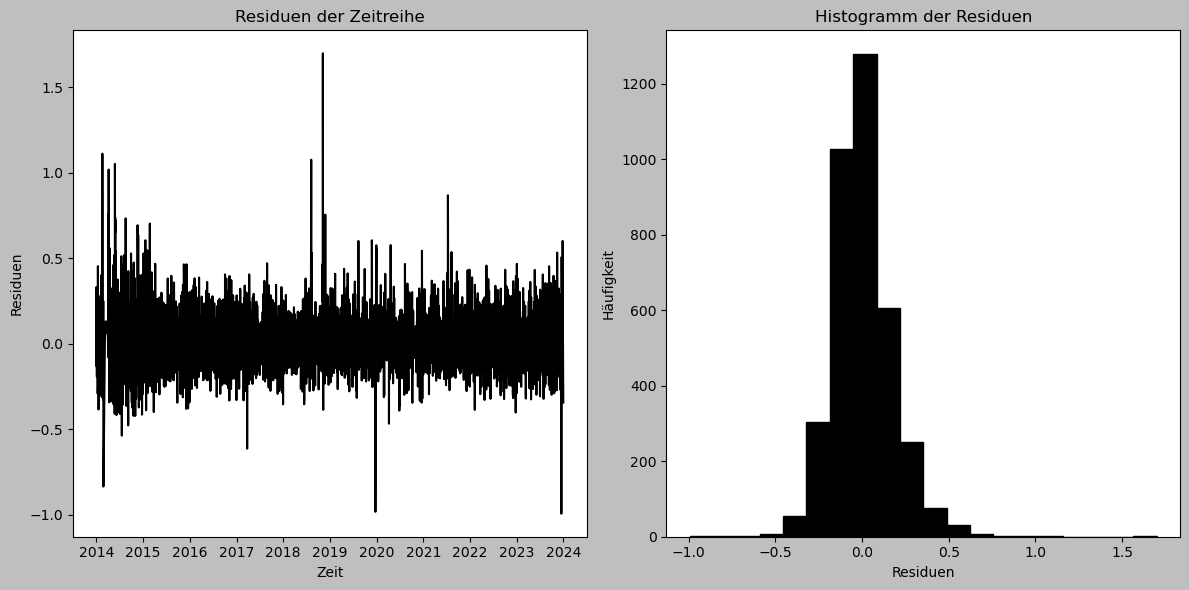

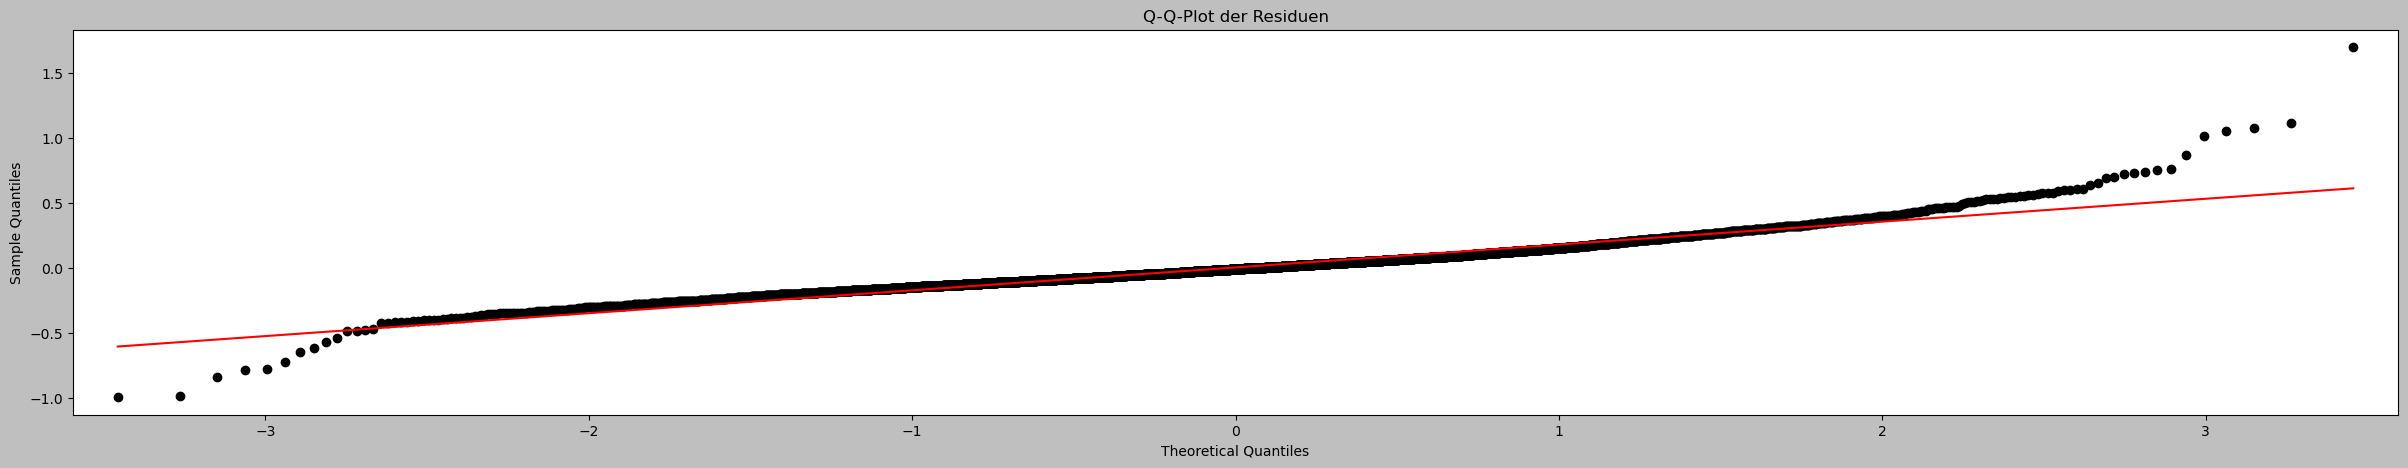

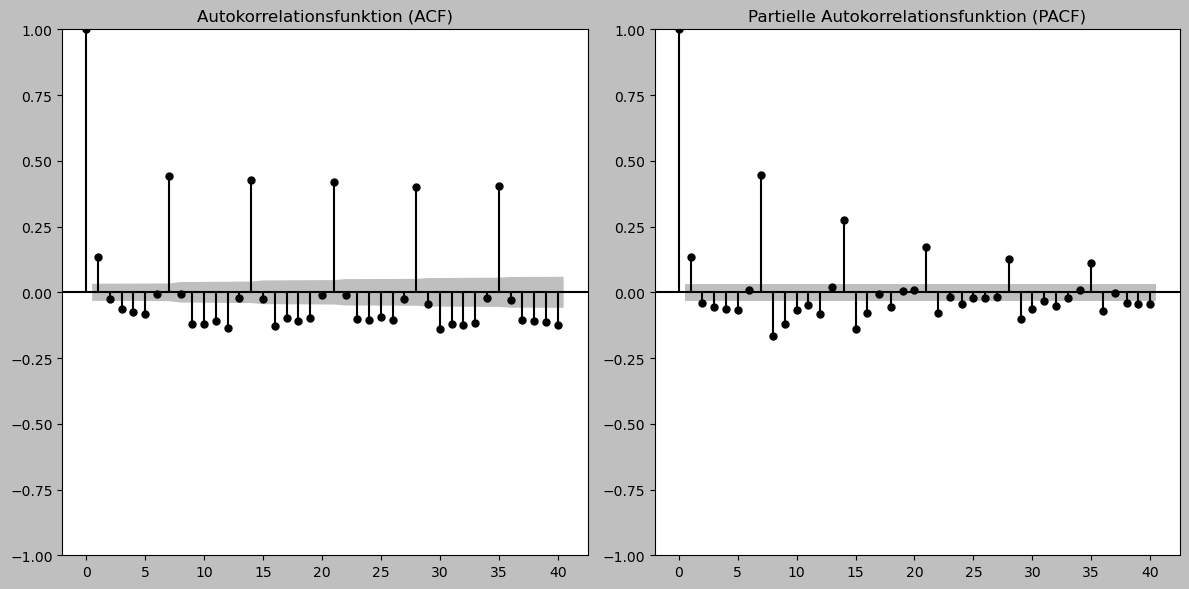

In [23]:
# Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC)
print(f"AIC: {fit_daily2.aic}")
print(f"BIC: {fit_daily2.bic}")

# Log-Likelihood des Modells
print(f"Log-Likelihood: {fit_daily2.llf}")

# Summe der quadrierten Residuen (SSR)
print(f"Sum of Squared Residuals (SSR): {fit_daily2.sse}")

# Tatsächliche Werte und vorhergesagte Werte
y_true = df_daily['calls']
y_pred = fit_daily2.fittedvalues

# Mean Squared Error (MSE) und Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
print(f"MAPE: {mape:.2f}%")

# Residuen des ETS-Modells extrahieren
residuals = fit_daily2.resid

# Residuen plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Zeitreihenplot der Residuen
axes[0].plot(residuals)
axes[0].set_title("Residuen der Zeitreihe")
axes[0].set_xlabel("Zeit")
axes[0].set_ylabel("Residuen")

# Histogramm der Residuen
axes[1].hist(residuals, bins=20, edgecolor="k")
axes[1].set_title("Histogramm der Residuen")
axes[1].set_xlabel("Residuen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# Q-Q-Plot der Residuen
sm.qqplot(residuals, line="s")
plt.title("Q-Q-Plot der Residuen")
plt.show()

# ACF und PACF der Residuen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], lags=40)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.tight_layout()
plt.show()

AIC: 176300.34146212463
BIC: 177758.4217977118
Log-Likelihood: -87975.17073106232
Sum of Squared Residuals (SSR): 554620.2312264235
MSE: 18.068159735028132
RMSE: 4.25066579902821
MAE: 3.134712246757879
MAPE: inf%


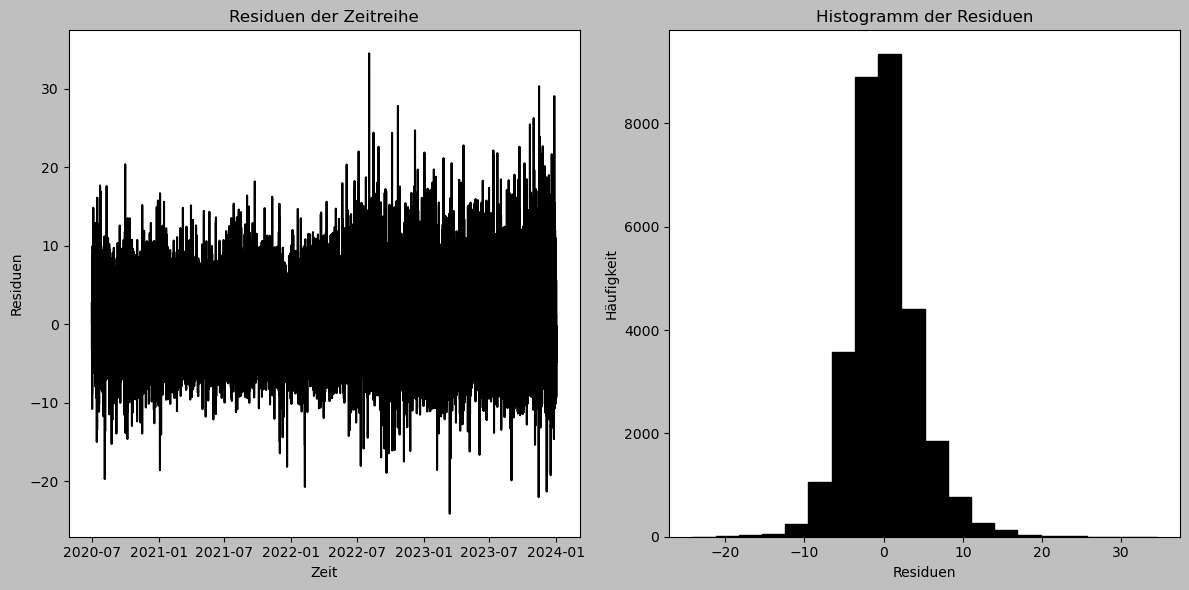

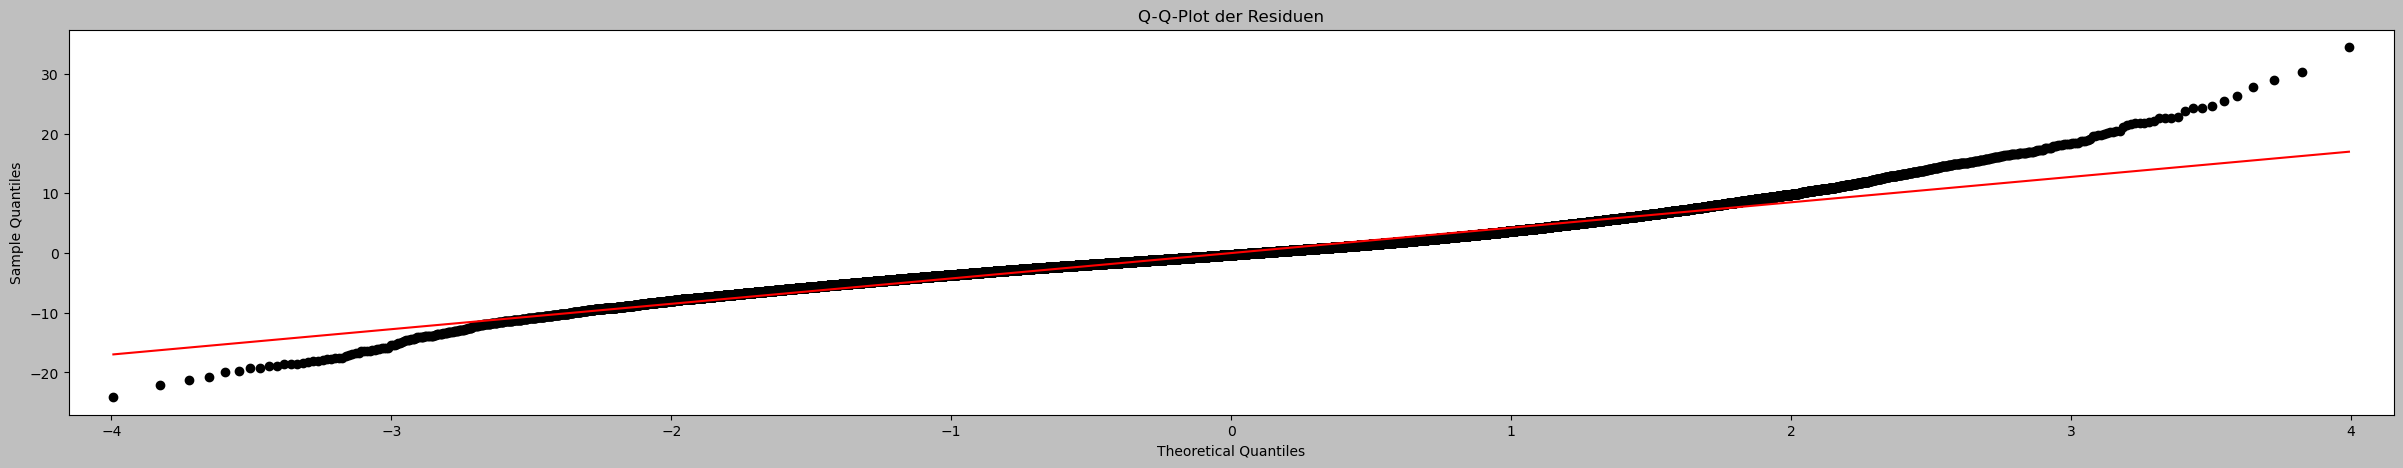

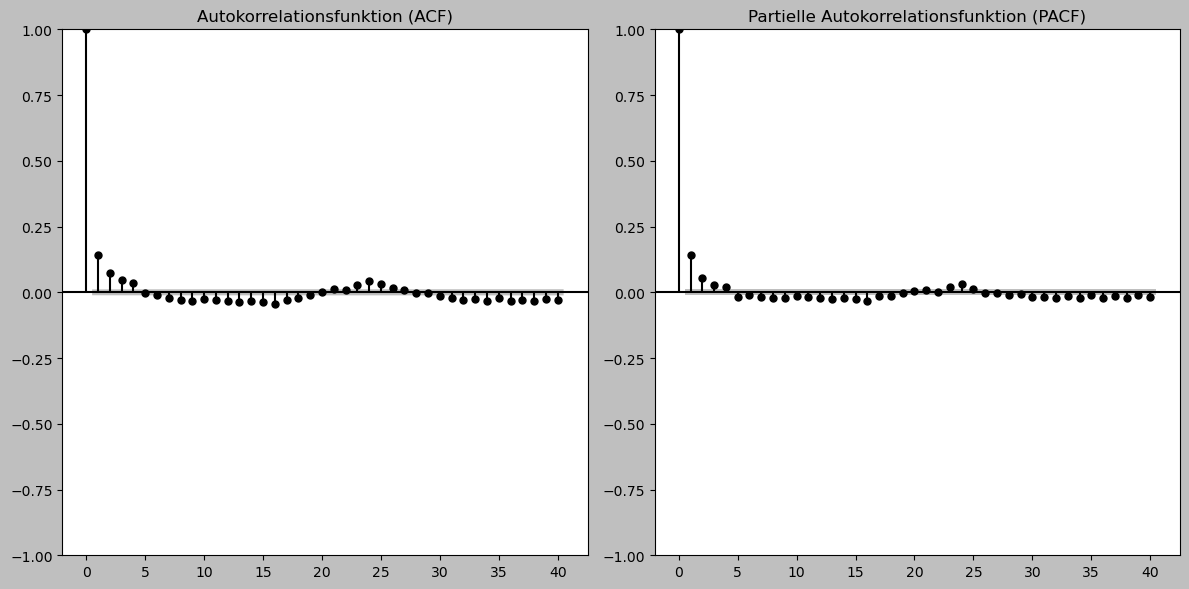

In [24]:
# Akaike Information Criterion (AIC) und Bayesian Information Criterion (BIC)
print(f"AIC: {fit_hourly2.aic}")
print(f"BIC: {fit_hourly2.bic}")

# Log-Likelihood des Modells
print(f"Log-Likelihood: {fit_hourly2.llf}")

# Summe der quadrierten Residuen (SSR)
print(f"Sum of Squared Residuals (SSR): {fit_hourly2.sse}")

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tatsächliche Werte und vorhergesagte Werte
y_true = df_hourly['calls']
y_pred = fit_hourly2.fittedvalues

# Mean Squared Error (MSE) und Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Mean Absolute Percentage Error (MAPE)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100
print(f"MAPE: {mape:.2f}%")


# Residuen des ETS-Modells extrahieren
residuals = fit_hourly2.resid

# Residuen plotten
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Zeitreihenplot der Residuen
axes[0].plot(residuals)
axes[0].set_title("Residuen der Zeitreihe")
axes[0].set_xlabel("Zeit")
axes[0].set_ylabel("Residuen")

# Histogramm der Residuen
axes[1].hist(residuals, bins=20, edgecolor="k")
axes[1].set_title("Histogramm der Residuen")
axes[1].set_xlabel("Residuen")
axes[1].set_ylabel("Häufigkeit")

plt.tight_layout()
plt.show()

# Q-Q-Plot der Residuen
sm.qqplot(residuals, line="s")
plt.title("Q-Q-Plot der Residuen")
plt.show()

# ACF und PACF der Residuen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(residuals, ax=axes[0], lags=40)
axes[0].set_title("Autokorrelationsfunktion (ACF)")
sm.graphics.tsa.plot_pacf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Partielle Autokorrelationsfunktion (PACF)")
plt.tight_layout()
plt.show()

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [8]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## Moving, Smoothing and Evaluation
### Berechnung des Gleitenden Mittelwertes


In [9]:
# Berechnung des Gleitenden Mittelwertes
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_daily, 7) # Berechnung des Mittelswertes der letzten sieben Tage

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [26]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    
    # Plot actual values first to keep them in the background
    plt.plot(series, label="Actual values", color=cmap.colors[3])

    # Plot rolling mean trend
    plt.plot(rolling_mean, "g", label="Rolling mean trend", color=cmap.colors[1])

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()


In [ ]:
plotMovingAverage (df_daily['calls'], 7)



plotMovingAverage (df_daily['calls'], 30)



plotMovingAverage (df_daily['calls'], 365) 



plotMovingAverage(df_daily['calls'], 30, plot_intervals=True, plot_anomalies= True)


### Gewichteter Durchschnitt

In [10]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [11]:
weighted_average(df_daily['calls'], [0.6, 0.3, 0.1])

263.40000000000003

### Exponentielle Glättung

In [12]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

### Exponentielle Glättung

In [27]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [28]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-v0_8-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(series.values, "c", label = "Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True)

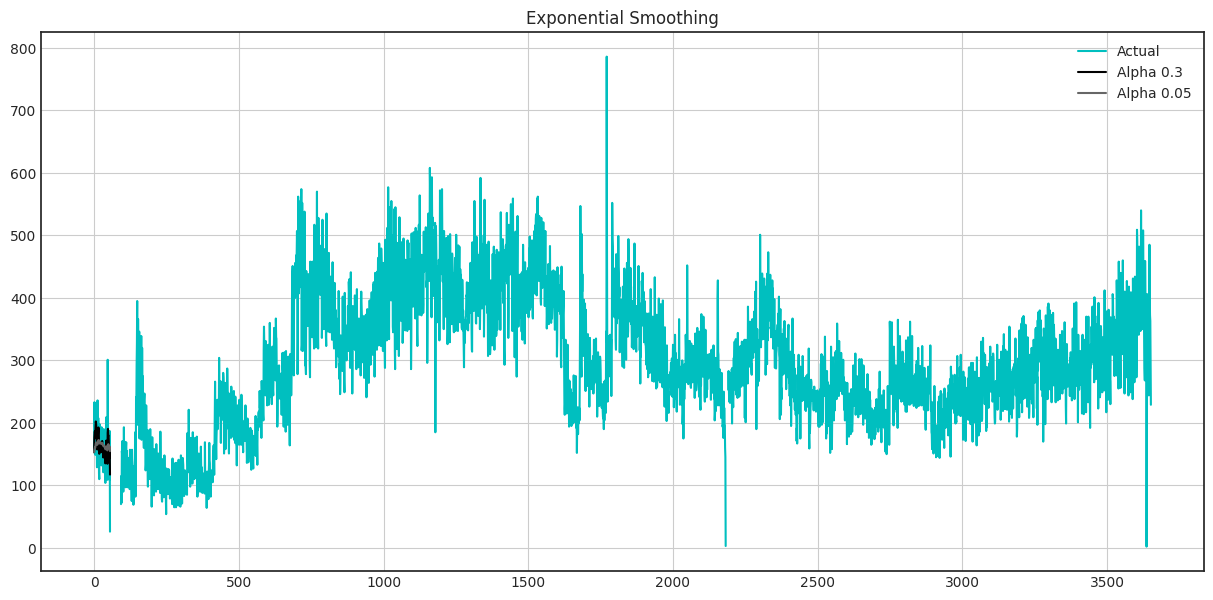

In [29]:
plotExponentialSmoothing(df_daily.calls, [0.3, 0.05])

Alpha ist der Glättungs-Faktor. Je kleiner alpha ist, desto mehr Einfluss haben die vorherigen Ereignisse im Vergleich zum momentanen Ereignis.


## Double exponential smoothing


In [30]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-v0_8-white'):    
        plt.figure(figsize=(20, 8))
        plt.plot(series.values, label = "Actual")
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

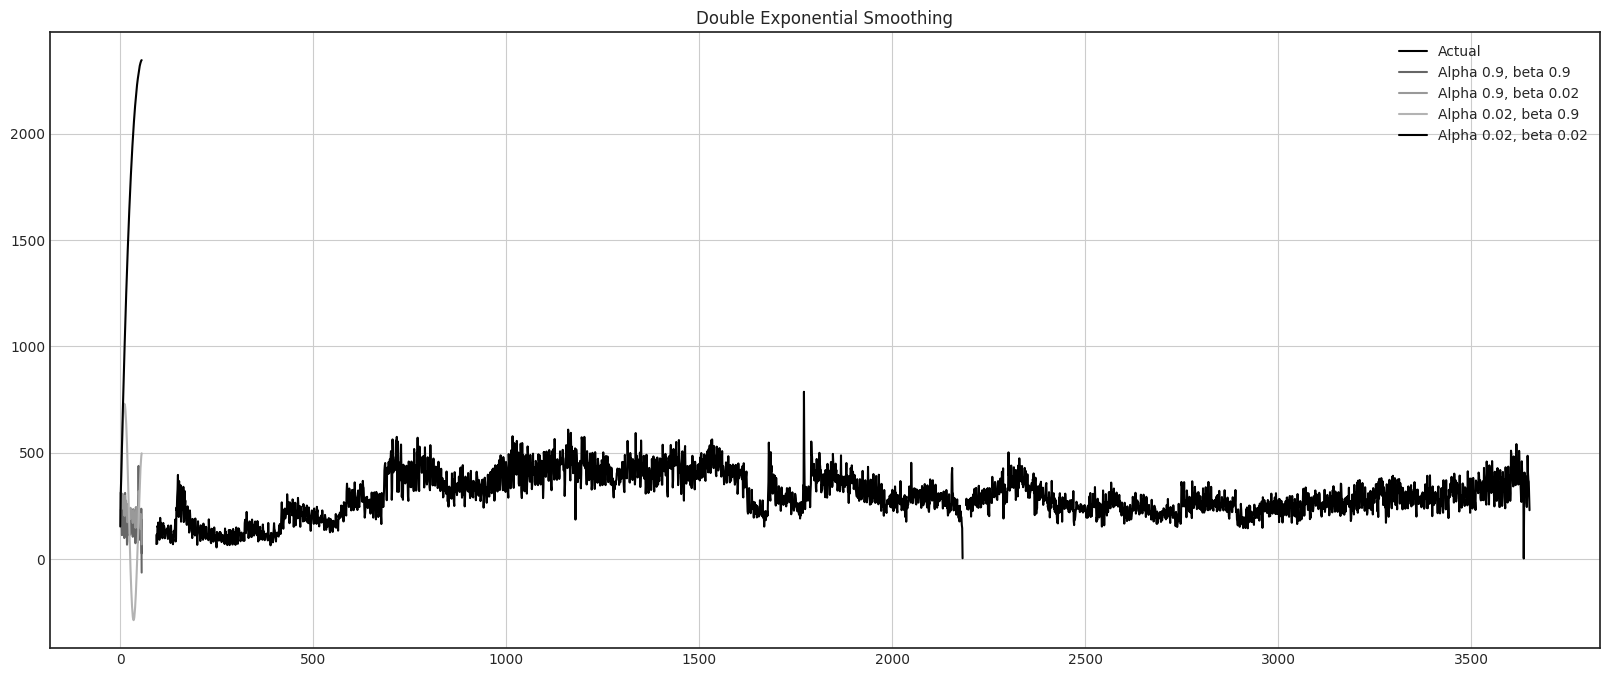

In [31]:
plotDoubleExponentialSmoothing(df_daily.calls, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Die doppelte Exponentielle Glättung beinhaltet die Komponenten Level und Trend. 

### Triple Exponential Smoothing aka Holt-Winters

Dieses Verfahren berücksichtigt nicht nur Level und Trend, sondern auch Season/Saison.

In [32]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   
      
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Time Series Cross Validation

In [33]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(actual, predictions)
        errors.append(error)
        
    return np.mean(np.array(errors))

NameError: name 'mean_squared_error' is not defined

In [34]:
%%time
data = df_daily.calls[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

NameError: name 'timeseriesCVscore' is not defined

In [35]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import numpy as np
import pandas as pd

# Check for negative values
negative_values = df_daily.calls[df_daily.calls < 0]
print(f"Negative values in calls: {negative_values}")

if len(negative_values) > 0:
    raise ValueError("The data contains negative values, which is not suitable for mean_squared_log_error.")

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(actual, predictions)
        errors.append(error)
        
    return np.mean(np.array(errors))

data = df_daily.calls[:-20]  # Belassen Sie einige Daten zum Testen

# Initialisieren Sie die Modellparameter alpha, beta und gamma
x = [0, 0, 0] 

# Minimieren Sie die Verlustfunktion
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Nehmen Sie die optimalen Werte...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...und trainieren Sie das Modell mit ihnen, indem Sie die nächsten 50 Stunden vorhersagen
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

Negative values in calls: Series([], Name: calls, dtype: float64)


ValueError: Input contains NaN.

In [37]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(series.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

AttributeError: 'SARIMAXResults' object has no attribute 'result'

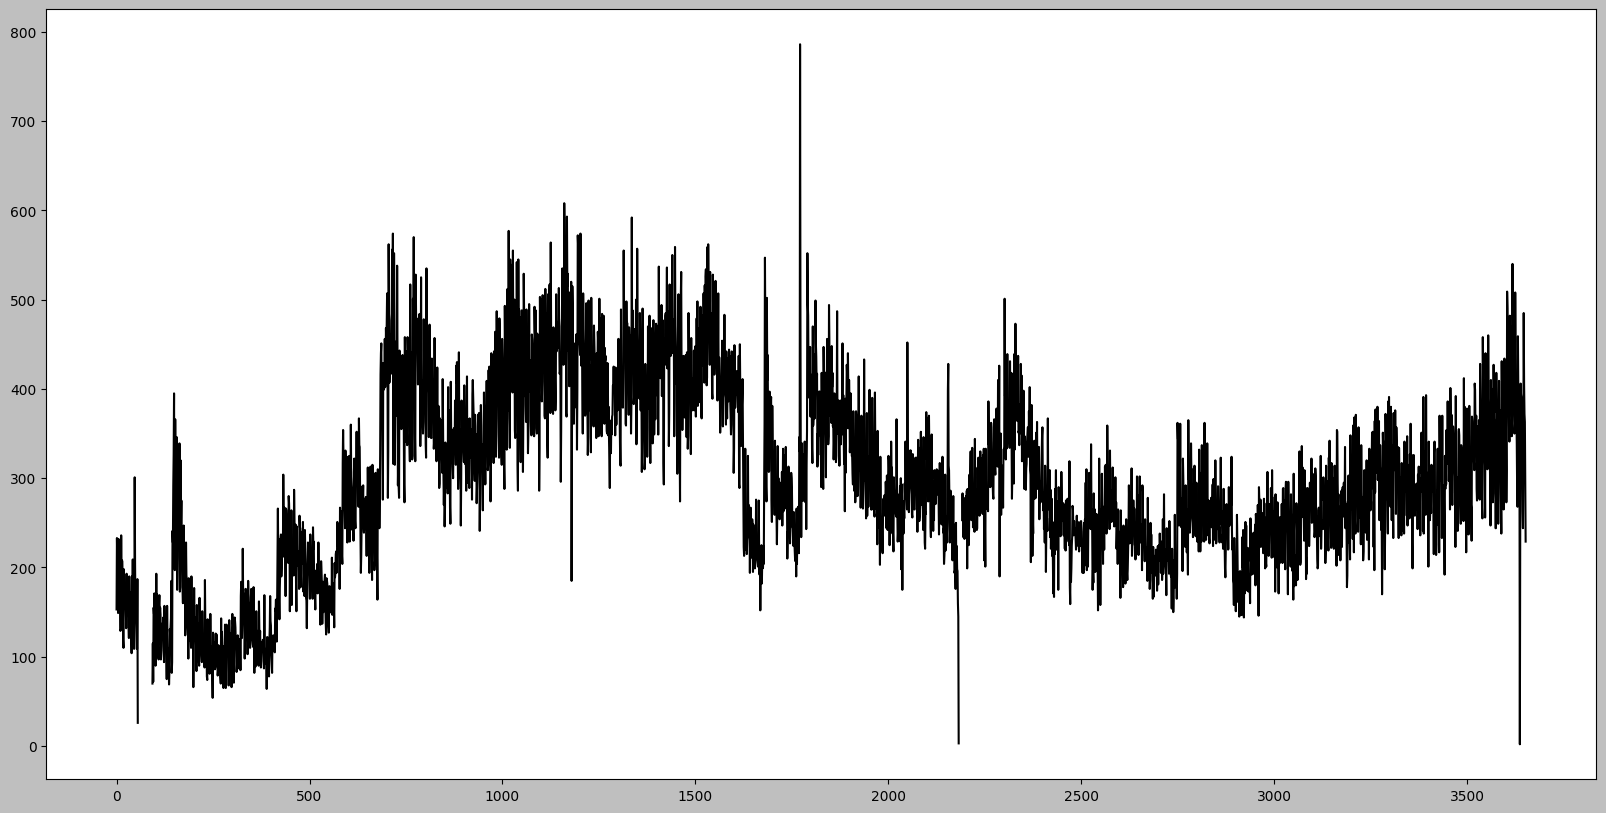

In [38]:
plotHoltWinters(df_daily.calls, plot_intervals=True, plot_anomalies=True)

In [39]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

AttributeError: 'SARIMAXResults' object has no attribute 'PredictedDeviation'

<Figure size 2500x500 with 0 Axes>

## Econometric approach

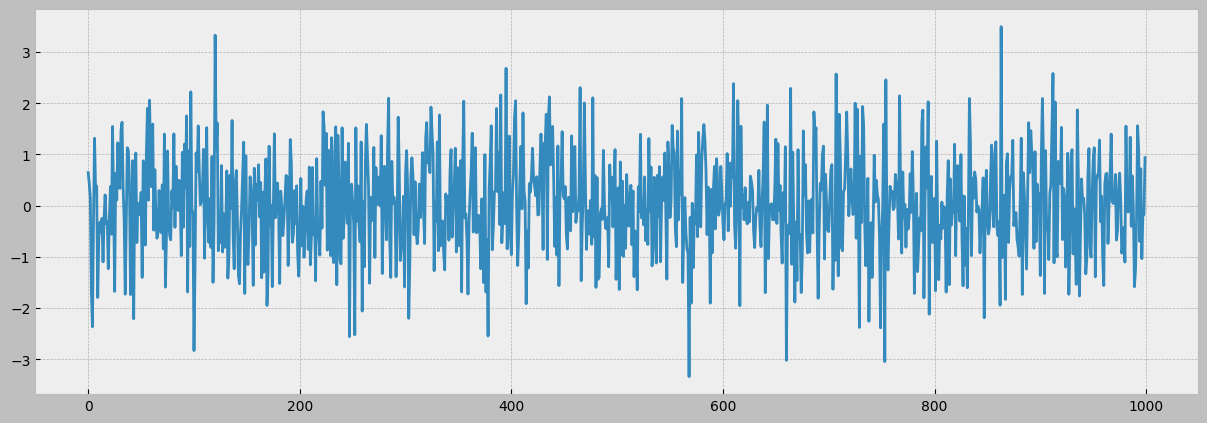

In [40]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

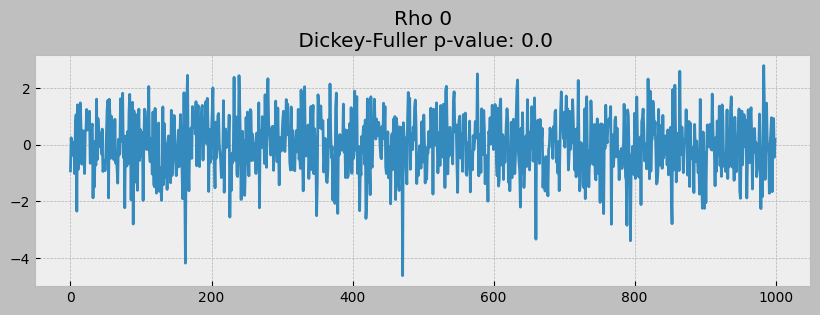

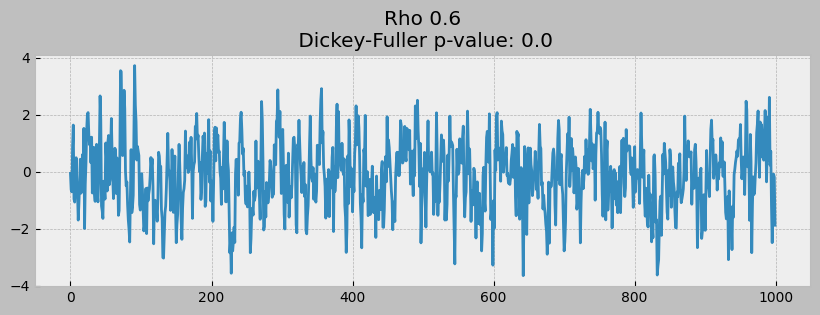

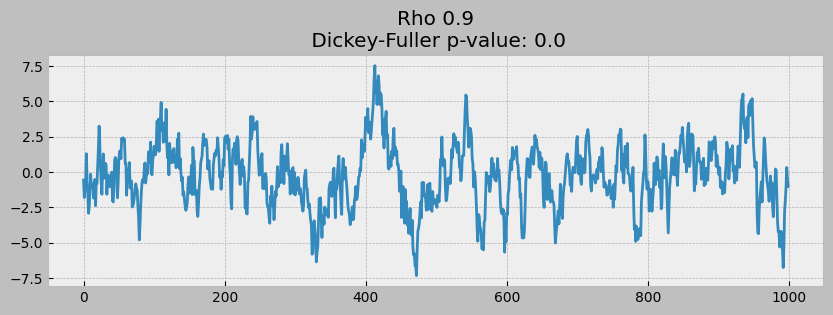

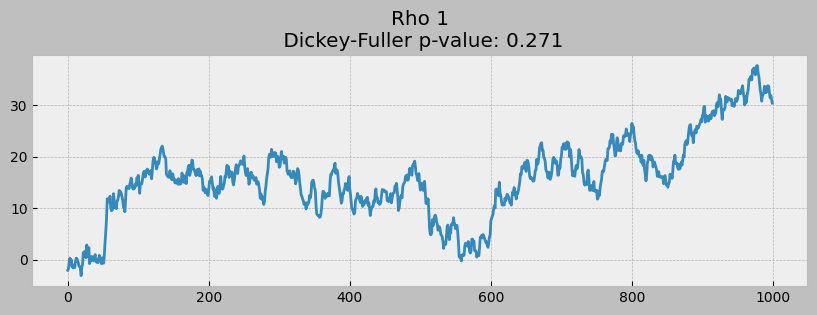

In [41]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)